## Importar librerias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interact

## Definir el periodo de simulacion

In [2]:
T = 150 # days
dates = pd.date_range(start = '2000-01-01', periods = T)

## Datos de entrada (inputs)

In [3]:
np.random.seed(1)
prec = 20 * np.random.random(T)
np.random.seed(2)
etp = 5 * np.random.random(T)

## Parametros del modelo

In [4]:
sm_max = 10  # Maxima capacidad de retencion del del suelo (mm) [10 - 90]
gamma  = 0.5 # Ratio de evaporacion () [0 - 1]
alpha  = 0.5 # Ratio de infiltracion () [0 - 1]
t_sup  = 1   # Tiempo concentracion del flujo superficial [0.8 - 2]
t_sub  = 5   # Tiempo concentracion del flujo subterraneo [2 - 10]

## Inicializar variables del modelo

In [5]:
inf   = np.zeros((T,1))   # Tasa de infiltracion [mm/t]
et    = np.zeros((T,1))   # Tasa de evapotranspiration [mm/t]
sm    = np.zeros((T+1,1)) # Contendio de humdedad en el suelo [mm] (suponemos que el suelo esta seco inicialmente)
sL    = np.zeros((T+1,1)) # Slow reservoir moisture [mm]
sF    = np.zeros((T+1,1)) # Fast reservoir moisture [mm]
Q_sub = np.zeros((T,1))   # Flujo subterraneo [mm/t]
Q_sup = np.zeros((T,1))   # Flujo superficial [mm/t]
Q_tot = np.zeros((T,1))   # Flujo total [mm/t]

## Simulacion

In [6]:
for t in range(T):

    ##### Humedad del suelo #####          
    sm_temp = max(min(sm[t] + prec[t] - inf[t], sm_max), 0)

    ##### Infiltracion #####
    inf[t] = inf[t] + max(sm[t] + prec[t] - inf[t] - sm_max, 0) + min(sm[t] + prec[t] - inf[t], 0)

    ##### Evapotranspiracion #####
    W = min(np.abs(sm[t]/sm_max)*gamma, 1) # Factor de correccion de la evapotranspiracion
    et[t] = W * etp[t] # Calculo de la evapotranspiracion

    ##### Humedad del suelo (t+1) #####
    sm[t+1] = max(min(sm_temp - et[t], sm_max), 0) # Compute the water balance

    ##### Flujo subterraneo ######
    Q_sub[t] = 1/t_sub * sL[t]
    sL[t+1] = sL[t] + (1-alpha)*inf[t] - Q_sub[t]

    ##### Flujo superficial #####
    sF[t+1] = sF[t] +  alpha*inf[t] - 1/t_sup*sF[t]
    Q_sup[t] = 1/t_sup * sF[t]

    ##### Flujo total #####
    Q_tot[t] = Q_sup[t] + Q_sub[t]

## Visualizacion de los resultados

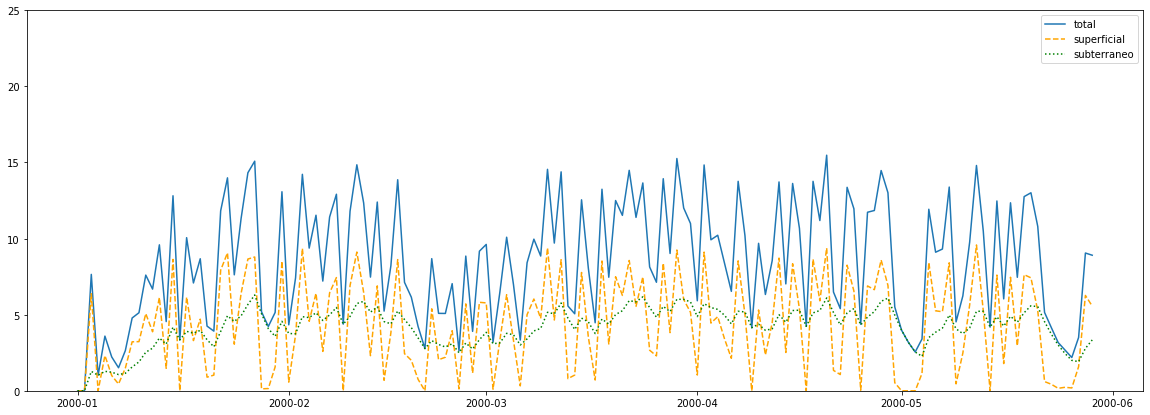

In [37]:
plt.figure(figsize=(20,7))
plt.plot(dates,Q_tot, label = 'total')
plt.plot(dates,Q_sup, linestyle = '--', color = 'orange',   label = 'superficial')
plt.plot(dates,Q_sub, linestyle = ':',  color = 'green', label = 'subterraneo')
plt.ylim(0,25) # para fijar los limites del eje y, en este caso 0 y 25
plt.legend()
plt.show()

## Vamos a intentar entender un poco mejor el model usando visualizacion interactiva

In [36]:
#######################################################################
# Parametros del modelo
#######################################################################
# sm_max: Maxima capacidad de retencion del del suelo (mm) [10-90]
# ratio_evap:  Ratio de evapotranspiracion () [0-1]
# ratio_inf:  Ratio de infiltracion () [0-1]
# t_sup:  Tiempo concentracion del flujo superficial [0.8 - 2]
# t_sub:  Tiempo concentracion del flujo subterraneo [2 - 10]

@interact(sm_max = (10, 90, 1), ratio_evap = (0.01, 0.99, 0.01), ratio_inf = (0.01, 0.99, 0.01), t_sup = (0.8,2,0.1), t_sub = (2,10,0.1))

def modelo_hidrologico(sm_max=10, ratio_evap=0.5, ratio_inf=0.5, t_sup=1, t_sub=5): # aqui damos los valores iniciales de los parametros)

    #######################################################################
    # Inicializar variables
    #######################################################################
    inf   = np.zeros((T,1))   # Lluvia infiltrada [mm/t]
    sup   = np.zeros((T,1))   # Lluvia acumulada en superficie [mm/t]
    et    = np.zeros((T,1))   # Tasa de evapotranspiration [mm/t]
    sm    = np.zeros((T+1,1)) # Contendio de humdedad en el suelo [mm] (suponemos que el suelo esta seco inicialmente)
    sL    = np.zeros((T+1,1)) # Slow reservoir moisture [mm]
    sF    = np.zeros((T+1,1)) # Fast reservoir moisture [mm]
    Q_sub = np.zeros((T,1))   # Flujo subterraneo [mm/t]
    Q_sup = np.zeros((T,1))   # Flujo superficial [mm/t]
    Q_tot = np.zeros((T,1))   # Flujo total [mm/t]

    #######################################################################
    # Simulacion
    #######################################################################
    for t in range(T):

        ##### Humedad del suelo #####          
        sm_temp = max(min(sm[t] + prec[t], sm_max), 0)

        ##### Lluvia infiltrada #####
        inf[t] = max(sm[t] + prec[t] - sm_max, 0) * ratio_inf
        
        ##### Lluvia acumulada en superficie #####
        sup[t] = max(sm[t] + prec[t] - sm_max, 0) * (1- ratio_inf)

        ##### Evapotranspiracion #####
        W = min(np.abs(sm[t]/sm_max)*ratio_evap, 1) # Factor de correccion de la evapotranspiracion
        et[t] = W * etp[t] # Calculo de la evapotranspiracion

        ##### Humedad del suelo (t+1) #####
        sm[t+1] = max(min(sm_temp - et[t], sm_max), 0) # Compute the water balance

        ##### Flujo subterraneo ######
        Q_sub[t] = 1/t_sub * sL[t]
        sL[t+1] = sL[t] + inf[t] - Q_sub[t]

        ##### Flujo superficial #####
        Q_sup[t] = 1/t_sup * sF[t]
        sF[t+1] = sF[t] +  sup[t] - Q_sup[t]

        ##### Flujo total #####
        Q_tot[t] = Q_sup[t] + Q_sub[t]

    #######################################################################
    # Visualizacion de los resultados
    #######################################################################
    plt.figure(figsize=(20,7))
    plt.plot(dates,Q_tot, label = 'total')
    plt.plot(dates,Q_sup, linestyle = '--', color = 'orange',   label = 'superficial')
    plt.plot(dates,Q_sub, linestyle = ':',  color = 'green', label = 'subterraneo')
    plt.ylim(0,25) # para fijar los limites del eje y, en este caso 0 y 25
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=10, description='sm_max', max=90, min=10), FloatSlider(value=0.5, descri…

Entender el concepto de calibracion de un modelo y para los que ya sabeis que es la calibracion, como ayuda a comprender el modelo en sí. Que significa cada parametro, que parametros influencian mas el resultado y comprobar que el model se comporta de una manera logica.